# EIT Continuous Model Complex-Valued Tests

This work aims to set first tests with EIT implementantion using FENICSx library, aiming to solve the complex valued case, explaining some of the fundamentals in the library implementation. In this context, we will be using the Continuous Model, testing initially with trivial simulated functions and simple meshes, adding more information and complexity as advancing.

More information and explanations about some steps can be seen in the FENICSx tutorial: https://jsdokken.com/dolfinx-tutorial/chapter1/complex_mode.html.

## EIT Continuous Model

Given a domain $\Omega \in \mathbb R^2$, an admitivity $\gamma: \Omega \to \mathbb C$, a potential distribution $u : \Omega \to \mathbb  C$ and a current $g : \partial \Omega \to \mathbb R$ in the border $\partial \Omega$ of $\Omega$, the EIT Continuous Model stablishes the following PDE:

$$
\nabla \cdot ( \gamma \nabla u) = 0, \text{ in } \Omega\\
\gamma \frac{\partial u}{\partial \eta} = g, \text{ in } \partial \Omega
$$

First equation also may be written as $div(\gamma \nabla u) = g$.

This PDE with stablished conditions may also be transformed in a weak variational formulation. Basically, we want to find $u$ such that for any given $v \in H^1_{\Diamond}$, it solves:

$$
\int_{\Omega} \gamma \nabla u \cdot \nabla v dx = \int_{\partial \Omega} g v dS
$$,

where $H^1_{\Diamond} = \{f \in H^1 : \int_{\partial \Omega} f = 0\}$.

## Implementation

In [ ]:
import sys
import dolfinx
from mpi4py import MPI #import parallel communicator
import numpy as np
import ufl
print("Python version: ", sys.version)
print(f"DOLFINx version: {dolfinx.__version__} based on GIT commit: {dolfinx.git_commit_hash} of https://github.com/FEniCS/dolfinx/")


#Check type of number set in PETSc lib, returns error if not complex
from petsc4py import PETSc #Linear algebra lib
print(PETSc.ScalarType)
assert np.dtype(PETSc.ScalarType).kind == 'c'

Python version:  3.10.6 (main, Nov 14 2022, 16:10:14) [GCC 11.3.0]
DOLFINx version: 0.6.0 based on GIT commit: 24f86a9ce57df6978070dbee22b3eae8bb77235f of https://github.com/FEniCS/dolfinx/
<class 'numpy.complex128'>


## Tests with round domain

### Defining Domain

In [40]:
# Use gmesh to create a circular domain
import gmsh
gmsh.finalize()
gmsh.initialize()

disk = gmsh.model.occ.addDisk(0, 0, 0, 1, 1) #creates disk centered in (0,0,0) with axis (1,1)
gmsh.model.occ.synchronize()

gdim = 2 #variable to control disk dimension, where 2 stands for surface

# starts mesh object
gmsh.model.addPhysicalGroup(gdim, [disk], 1)

#control length of cells
gmsh.option.setNumber("Mesh.CharacteristicLengthMin",0.05)
gmsh.option.setNumber("Mesh.CharacteristicLengthMax",0.05)

gmsh.model.mesh.generate(gdim)


Info    : Meshing 1D...
Info    : Meshing curve 1 (Ellipse)
Info    : Done meshing 1D (Wall 0.312593s, CPU 0.002918s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.452222s, CPU 0.295341s)
Info    : 1550 nodes 3099 elements


In [41]:
from dolfinx.io import gmshio
import dolfinx
from mpi4py import MPI
import pyvista

pyvista.start_xvfb()

gmsh_model_rank = 0
mesh_comm = MPI.COMM_WORLD
domain, cell_markers, facet_markers = gmshio.model_to_mesh(gmsh.model, mesh_comm, gmsh_model_rank, gdim=gdim)

from dolfinx import fem
V = fem.FunctionSpace(domain, ("CG", 1)) #creates function space in domain



Please install `ipyvtklink` to use this feature: https://github.com/Kitware/ipyvtklink

Falling back to a static output.
  warnings.warn(



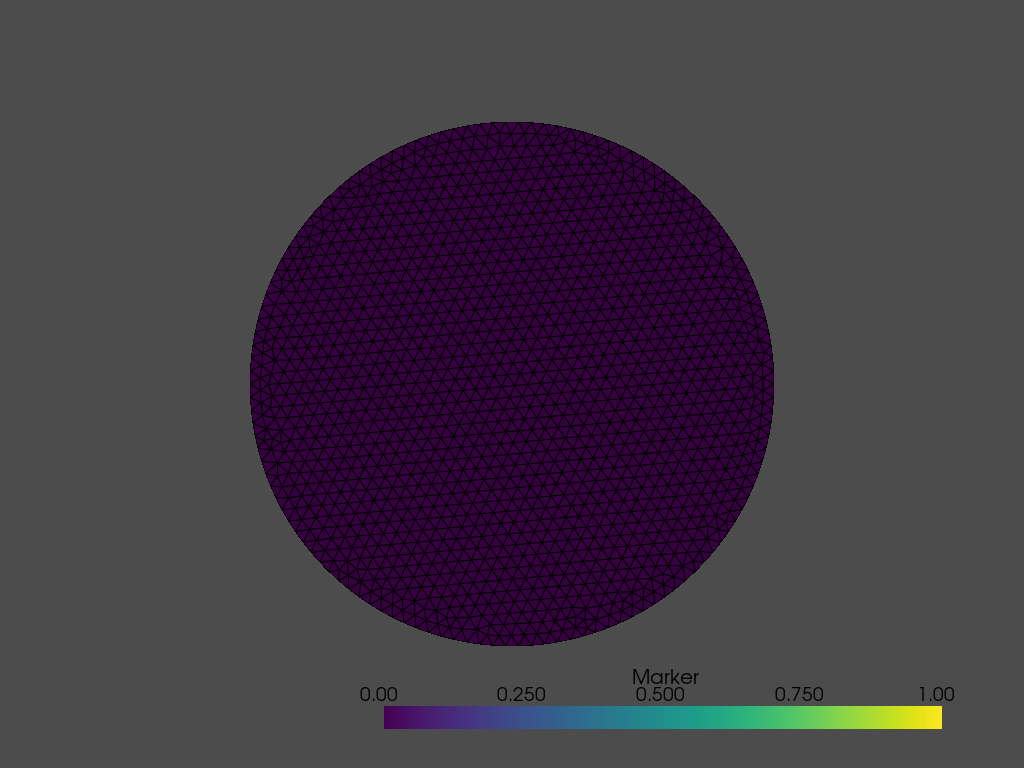

In [42]:
import numpy as np

topology, cell_types, x = dolfinx.plot.create_vtk_mesh(domain)

num_cells_local = domain.topology.index_map(domain.topology.dim).size_local
marker = np.zeros(num_cells_local, dtype=np.int32)

# Ploting mesh
p = pyvista.Plotter()
grid = pyvista.UnstructuredGrid(topology, cell_types, x)
grid.cell_data["Marker"] = marker
grid.set_active_scalars("Marker")
p.add_mesh(grid, show_edges=True)
p.view_xy()
if pyvista.OFF_SCREEN:
    figure = p.screenshot("disk.png")
p.show()

### Defining problem

In [43]:
# defining current  
import ufl
x = ufl.SpatialCoordinate(domain)
g = 4*x[1]**2 - 4*x[0]**2

In [44]:
#Trial and test functions
u = ufl.TrialFunction(V) #function u_h
v = ufl.TestFunction(V)

In [45]:
from petsc4py import PETSc

#gamma
gamma = dolfinx.fem.Constant(domain, PETSc.ScalarType(1+1j)) #defining constant 1+1j function over mesh

#Left hand side
gradu = ufl.grad(u)
gradv = ufl.grad(v)
dx = ufl.dx
ds = ufl.ds

a = (gamma * ufl.inner(gradu, gradv)) * dx #\int \nabla u * \overline \nabla v dx

#Right hand side
L = ufl.inner(g,v) * ufl.ds

#Obs: inner product is set to consider the conjugate in second term

In [46]:
#Solving problem
problem = dolfinx.fem.petsc.LinearProblem(a,L)
us = problem.solve()

### Plotting

In [47]:
import pyvista
pyvista.global_theme.font.color = "black"
pyvista.global_theme.color = "white"
pyvista.start_xvfb()
p_mesh = pyvista.UnstructuredGrid(*dolfinx.plot.create_vtk_mesh(domain,domain.topology.dim))
pyvista_cells, cell_types, geometry = dolfinx.plot.create_vtk_mesh(V)

grid = pyvista.UnstructuredGrid(pyvista_cells, cell_types, geometry)

grid.point_data["u_real"] = us.x.array.real
grid.point_data["u_imag"] = us.x.array.imag

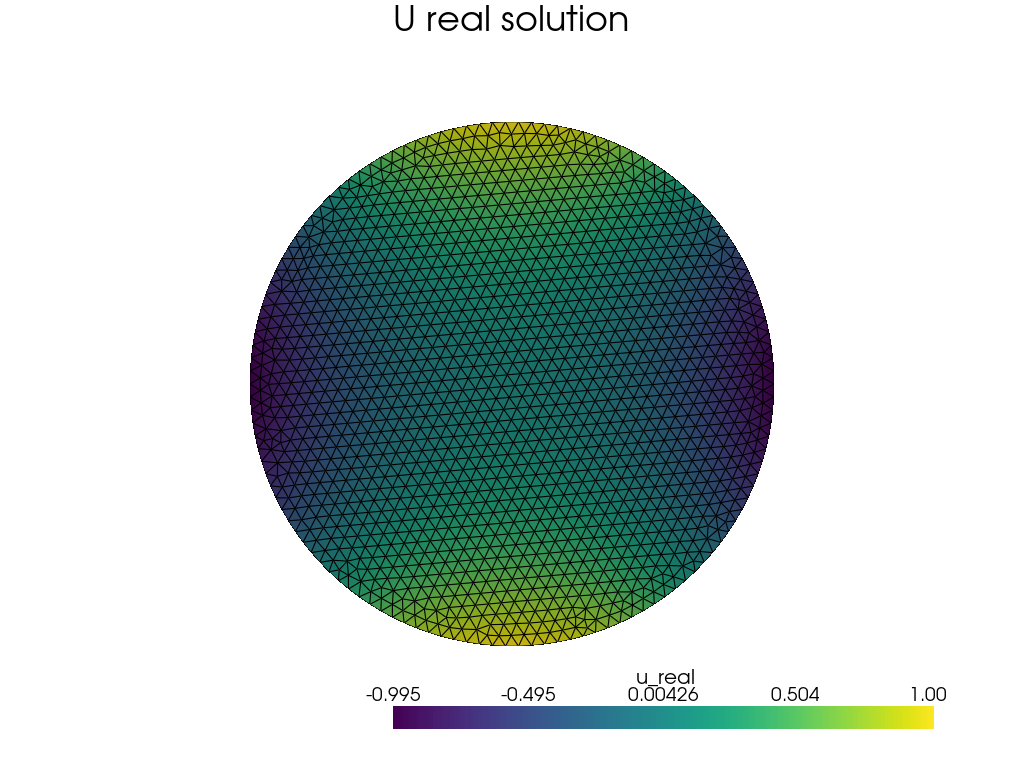

In [48]:
#Plot real
grid.set_active_scalars("u_real")
p_real = pyvista.Plotter()
p_real.add_text("U real solution", position="upper_edge", font_size=14, color="black")
p_real.add_mesh(grid, show_edges=True)
p_real.view_xy()
p_real.set_background("white")
if not pyvista.OFF_SCREEN:
    p_real.show()

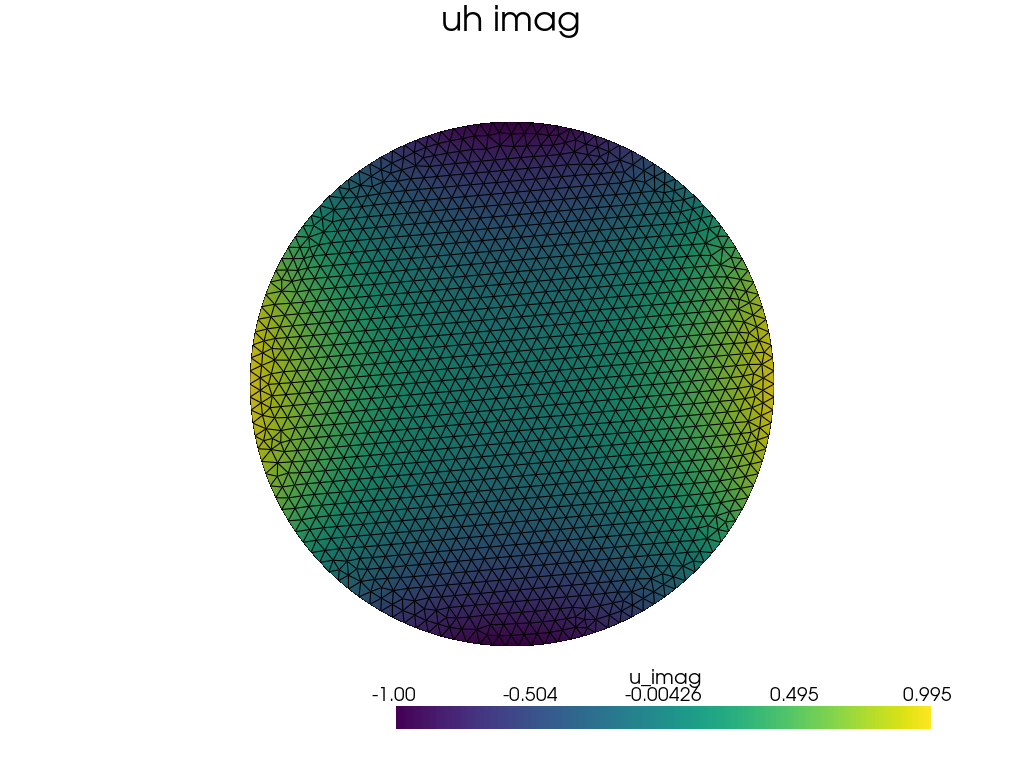

In [49]:
#Plot imag
grid.set_active_scalars("u_imag")
p_imag = pyvista.Plotter()
p_imag.add_text("uh imag", position="upper_edge", font_size=14, color="black")
p_imag.add_mesh(grid, show_edges=True)
p_imag.view_xy()
p_imag.set_background("white")
if not pyvista.OFF_SCREEN:
    p_imag.show()


### Error Analysis

In [50]:
# Defining exact solution
uex = dolfinx.fem.Function(V,dtype=np.complex128)
uex.interpolate(lambda x: (-1+1j)*x[0]**2 - (-1+1j)*x[1]**2)

grid = pyvista.UnstructuredGrid(pyvista_cells, cell_types, geometry)

grid.point_data["uex_real"] = uex.x.array.real
grid.point_data["uex_imag"] = uex.x.array.imag

In [54]:
l2error = dolfinx.fem.form(ufl.inner(us-uex,us-uex) * ufl.dx)
squareerror = dolfinx.fem.assemble_scalar(l2error)

l2normerror = np.sqrt(squareerror)
max_error = np.max(np.abs(squareerror))

print("L2 norm error: ", l2normerror)
print("Max error: ",max_error)

L2 norm error:  (0.012253564676421608+0j)
Max error:  0.00015014984727924736


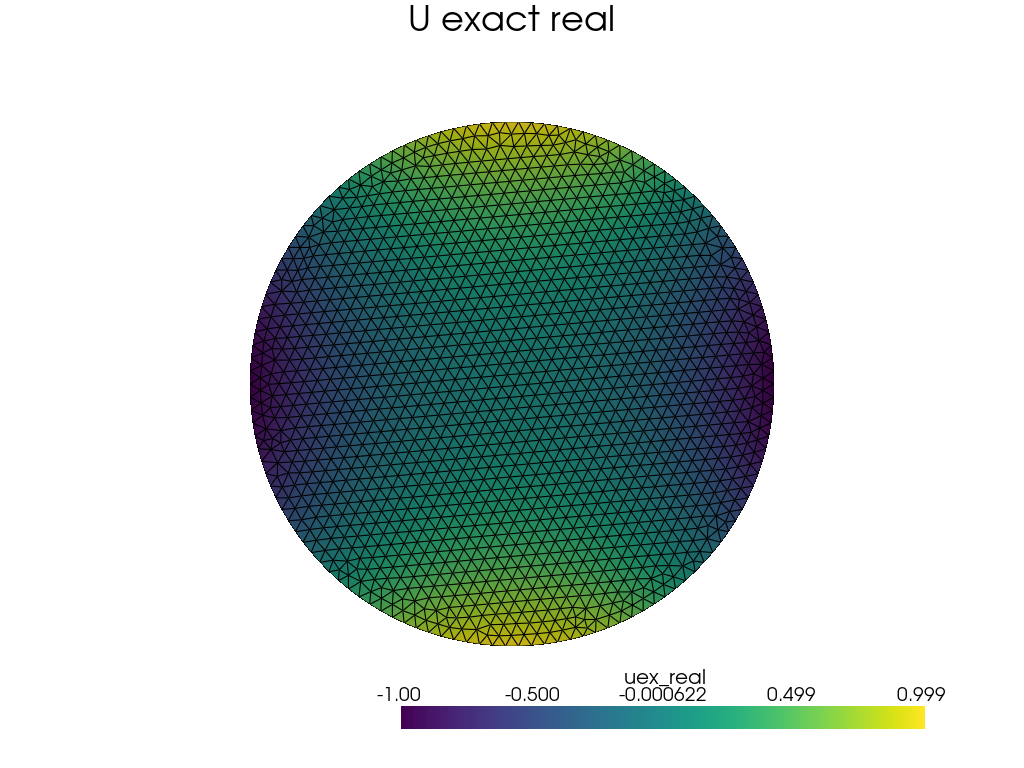

In [52]:
#Plot real
grid.set_active_scalars("uex_real")
p_real = pyvista.Plotter()
p_real.add_text("U exact real", position="upper_edge", font_size=14, color="black")
p_real.add_mesh(grid, show_edges=True)
p_real.view_xy()
p_real.set_background("white")
if not pyvista.OFF_SCREEN:
    p_real.show()

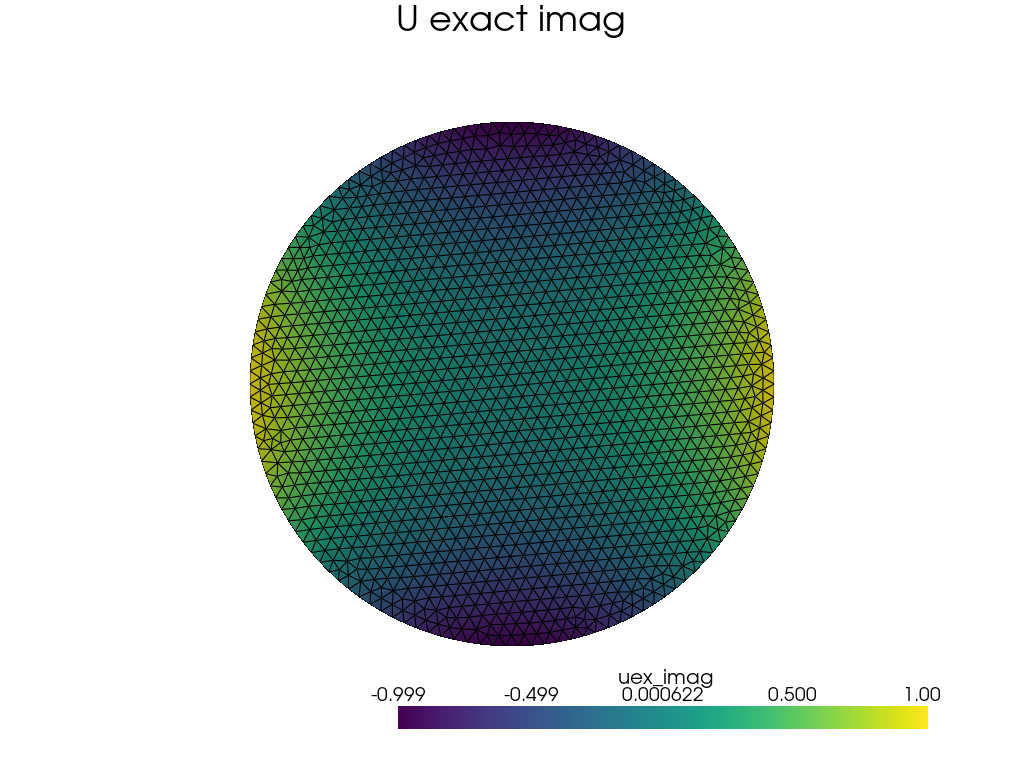

In [53]:
#Plot imag
grid.set_active_scalars("uex_imag")
p_real = pyvista.Plotter()
p_real.add_text("U exact imag", position="upper_edge", font_size=14, color="black")
p_real.add_mesh(grid, show_edges=True)
p_real.view_xy()
p_real.set_background("white")
if not pyvista.OFF_SCREEN:
    p_real.show()

## Tests with square domain



In [ ]:
# Create unit square mesh
mesh = dolfinx.mesh.create_unit_square(MPI.COMM_WORLD, 10, 10)

#Define function space
V = dolfinx.fem.FunctionSpace(mesh, ("CG", 1))

#Define functions 
# u_s = dolfinx.fem.Function(V,dtype=np.complex128)
# u_s.interpolate(lambda x: x[0]**2 - 1j*x[1]**2)
# g = dolfinx.fem.Function(V,dtype=np.complex128)
# g.interpolate(lambda x: x[0]**2 - x[1]**2)



In [ ]:
#Trial and test functions
u = ufl.TrialFunction(V) #function u_h
v = ufl.TestFunction(V)

In [ ]:
#gamma
gamma = dolfinx.fem.Constant(mesh, PETSc.ScalarType(1+1j)) #defining constant 1+1j function over mesh

#Left hand side
gradu = ufl.grad(u)
gradv = ufl.grad(v)
dx = ufl.dx
ds = ufl.ds

a = (gamma * ufl.inner(gradu, gradv)) * dx #\int \nabla u * \overline \nabla v dx

#Right hand side
L = ufl.inner(g,v) * ufl.ds

#Obs: inner product is set to consider the conjugate in second term

In [ ]:
problem = dolfinx.fem.petsc.LinearProblem(a,L)
us = problem.solve()

In [ ]:
## Plotting
import pyvista
pyvista.start_xvfb()
p_mesh = pyvista.UnstructuredGrid(*dolfinx.plot.create_vtk_mesh(mesh, mesh.topology.dim))
pyvista_cells, cell_types, geometry = dolfinx.plot.create_vtk_mesh(V)

grid = pyvista.UnstructuredGrid(pyvista_cells, cell_types, geometry)

grid.point_data["u_real"] = us.x.array.real
grid.point_data["u_imag"] = us.x.array.imag

NameError: name 'dolfinx' is not defined


Please install `ipyvtklink` to use this feature: https://github.com/Kitware/ipyvtklink

Falling back to a static output.
  warnings.warn(



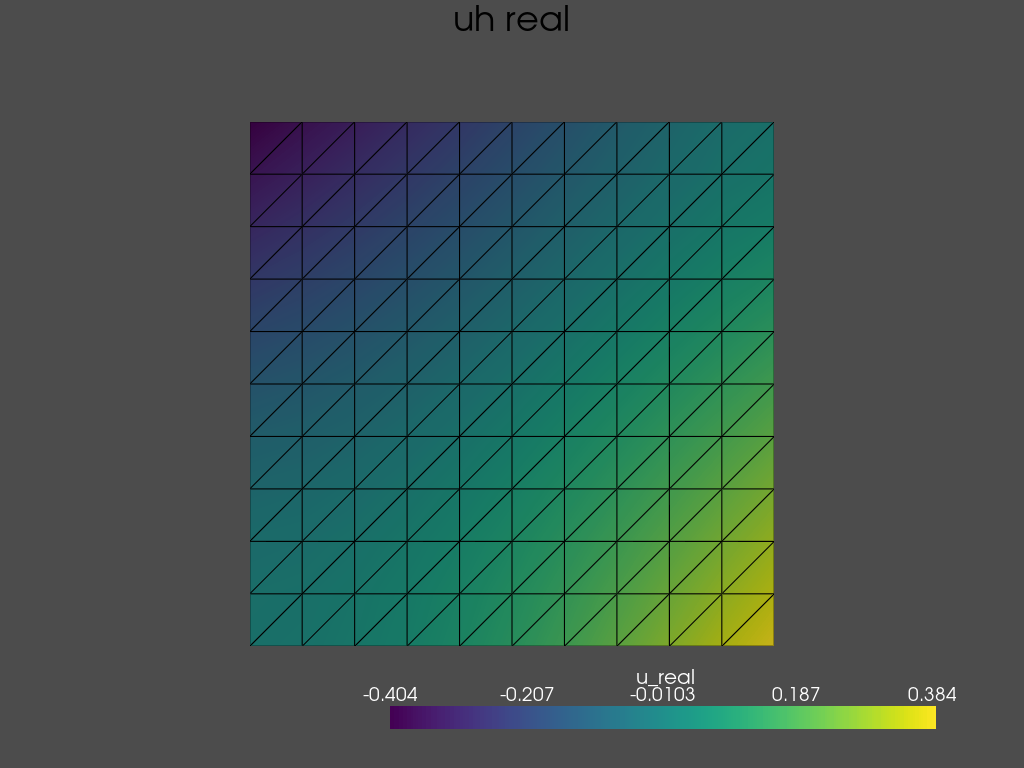

In [ ]:
#Plot real
grid.set_active_scalars("u_real")
p_real = pyvista.Plotter()
p_real.add_text("uh real", position="upper_edge", font_size=14, color="black")
p_real.add_mesh(grid, show_edges=True)
p_real.view_xy()
if not pyvista.OFF_SCREEN:
    p_real.show()

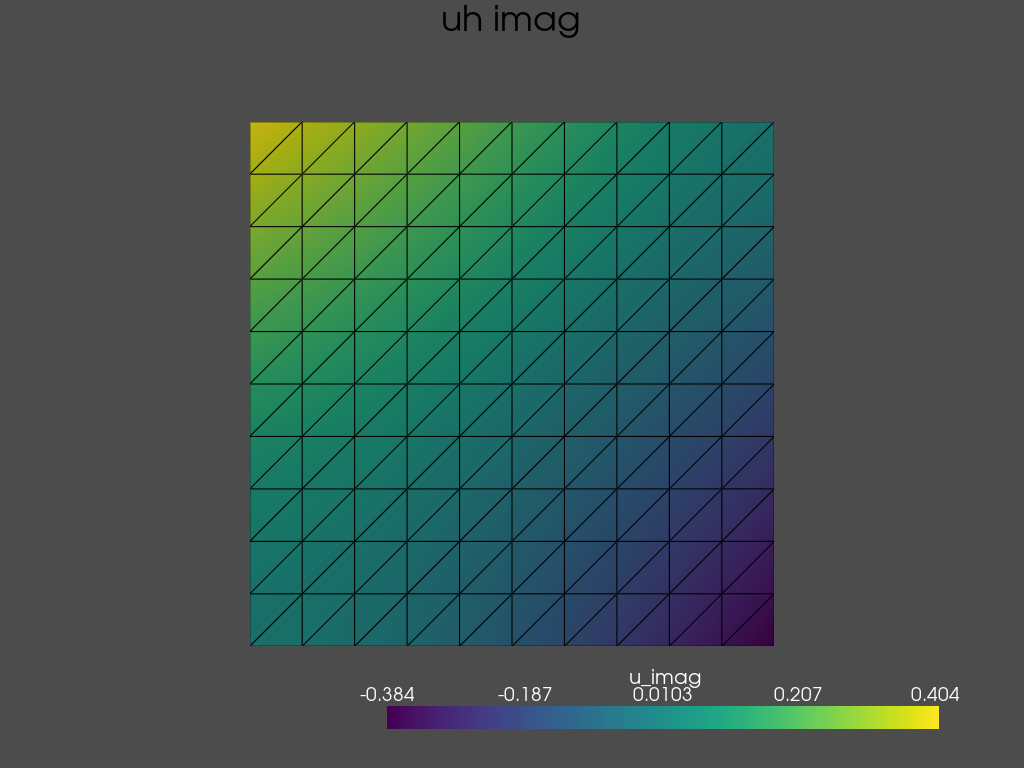

In [ ]:
grid.set_active_scalars("u_imag")
p_imag = pyvista.Plotter()
p_imag.add_text("uh imag", position="upper_edge", font_size=14, color="black")
p_imag.add_mesh(grid, show_edges=True)
p_imag.view_xy()
if not pyvista.OFF_SCREEN:
    p_imag.show()


In [27]:
#Calculating through L2 error
L2_error = dolfinx.fem.form(ufl.inner(us-uex, us-uex) * ufl.dx)
local_error = dolfinx.fem.assemble_scalar(L2_error) #gets result from calculation

global_error = np.sqrt(local_error)
max_error = np.max(us.x.array-uex.x.array)

In [28]:
print("Global error (L2 error)", global_error)
print("Max error", max_error)

Global error (L2 error) (2.0393541403464486+0j)
Max error (1.9925343380404992-1.9925343380405005j)


## Tests with square domain



In [ ]:
# Create unit square mesh
mesh = dolfinx.mesh.create_unit_square(MPI.COMM_WORLD, 10, 10)

#Define function space
V = dolfinx.fem.FunctionSpace(mesh, ("CG", 1))

#Define functions 
# u_s = dolfinx.fem.Function(V,dtype=np.complex128)
# u_s.interpolate(lambda x: x[0]**2 - 1j*x[1]**2)
# g = dolfinx.fem.Function(V,dtype=np.complex128)
# g.interpolate(lambda x: x[0]**2 - x[1]**2)



In [ ]:
#Trial and test functions
u = ufl.TrialFunction(V) #function u_h
v = ufl.TestFunction(V)

In [ ]:
#gamma
gamma = dolfinx.fem.Constant(mesh, PETSc.ScalarType(1+1j)) #defining constant 1+1j function over mesh

#Left hand side
gradu = ufl.grad(u)
gradv = ufl.grad(v)
dx = ufl.dx
ds = ufl.ds

a = (gamma * ufl.inner(gradu, gradv)) * dx #\int \nabla u * \overline \nabla v dx

#Right hand side
L = ufl.inner(g,v) * ufl.ds

#Obs: inner product is set to consider the conjugate in second term

In [ ]:
problem = dolfinx.fem.petsc.LinearProblem(a,L)
us = problem.solve()

In [ ]:
## Plotting
import pyvista
pyvista.start_xvfb()
p_mesh = pyvista.UnstructuredGrid(*dolfinx.plot.create_vtk_mesh(mesh, mesh.topology.dim))
pyvista_cells, cell_types, geometry = dolfinx.plot.create_vtk_mesh(V)

grid = pyvista.UnstructuredGrid(pyvista_cells, cell_types, geometry)

grid.point_data["u_real"] = us.x.array.real
grid.point_data["u_imag"] = us.x.array.imag

NameError: name 'dolfinx' is not defined


Please install `ipyvtklink` to use this feature: https://github.com/Kitware/ipyvtklink

Falling back to a static output.
  warnings.warn(



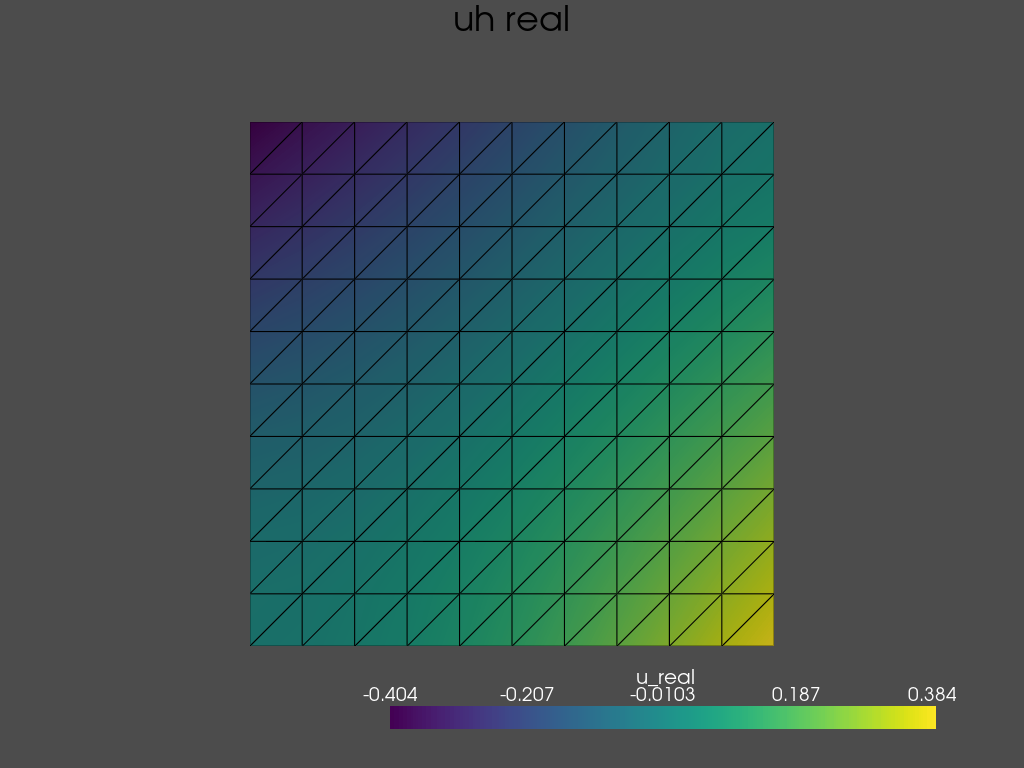

In [ ]:
#Plot real
grid.set_active_scalars("u_real")
p_real = pyvista.Plotter()
p_real.add_text("uh real", position="upper_edge", font_size=14, color="black")
p_real.add_mesh(grid, show_edges=True)
p_real.view_xy()
if not pyvista.OFF_SCREEN:
    p_real.show()

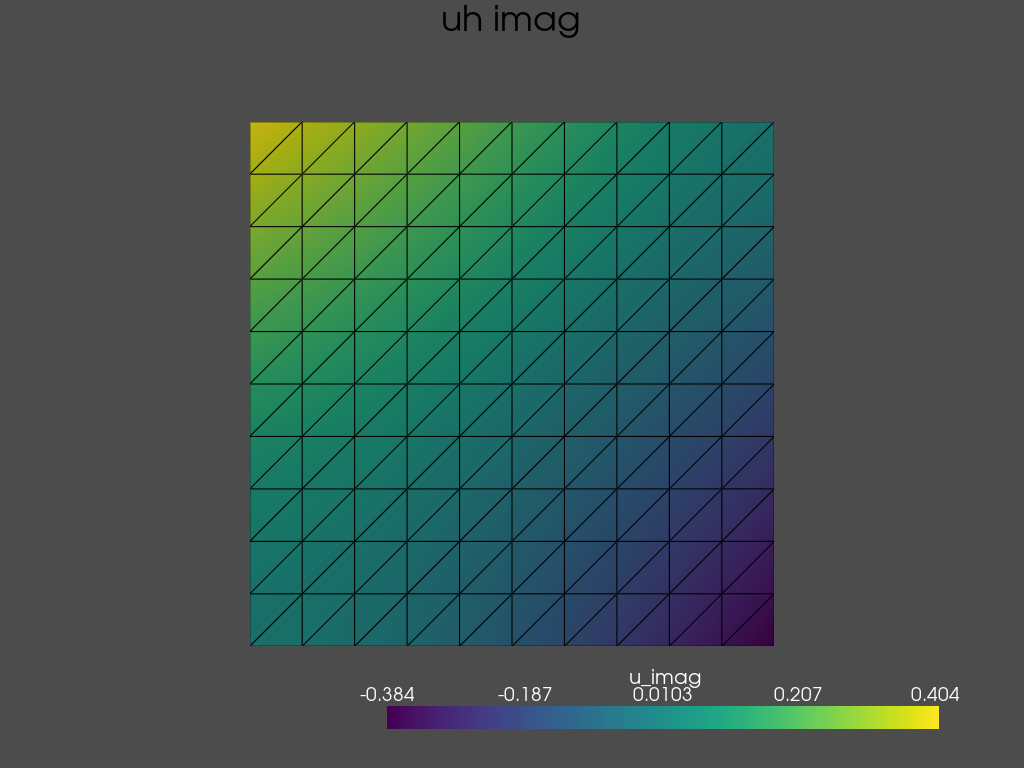

In [ ]:
grid.set_active_scalars("u_imag")
p_imag = pyvista.Plotter()
p_imag.add_text("uh imag", position="upper_edge", font_size=14, color="black")
p_imag.add_mesh(grid, show_edges=True)
p_imag.view_xy()
if not pyvista.OFF_SCREEN:
    p_imag.show()
